In [100]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [101]:
def ld_data (dir_name):
    # Load data in files from directory dir_name in a pandas dataframe
    df = pd.DataFrame()
    for filename in os.listdir(dir_name):
        funcs = []
        with open(os.path.join(dir_name, filename), 'r') as f:
            lines = f.read().splitlines()
            
            funcs = [line.strip().split(' ')[1][2:-1] for line in lines if not '@' in line.strip().split(' ')[1][2:-1] and not '?' in line.strip().split(' ')[1][2:-1]]

        # Concat all functions as string in df
        label = 'MALWARE' if filename.startswith('R-') else 'GOODWARE'
        df = pd.concat([df, pd.DataFrame({'filename': filename, 'label': label, 'funcs': ' '.join(funcs)}, index=[0])], ignore_index=True)
        
    return df


In [102]:
train_dt_dir_name = '../data/executable-functions/'
test_dt_dir_name = '../data/executable-functions-test/'
# test_dt_dir_name = '/archive/files/imports/'

In [103]:
train = ld_data(train_dt_dir_name)
test = ld_data(test_dt_dir_name)

In [104]:
print(len(test))
print(len(test[test['label'] == 'MALWARE']))
print(len(test[test['label'] == 'GOODWARE']))
test_goodware = test[test['label'] == 'GOODWARE']
test_malware = test[test['label'] == 'MALWARE']

97
53
44


In [105]:
# Create the tf-idf vectorizer
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train['funcs']).ceil()
test_g_vectors = vectorizer.transform(test_goodware['funcs']).ceil()
test_m_vectors = vectorizer.transform(test_malware['funcs']).ceil()

print(vectorizer.get_feature_names_out())
print(train['filename'][0])
print(train_vectors.toarray()[0])

['___lc_codepage_func' '___lc_collate_cp_func' '___lc_handle_func' ...
 'zwupdatewnfstatedata' 'zwwaitforsingleobject' 'zwwritefile']
R-Win32.Wannacry.sample
[0. 0. 0. ... 0. 0. 0.]


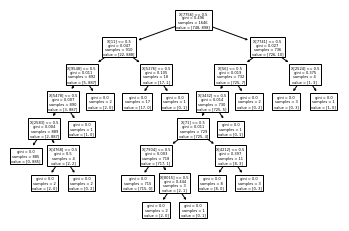

In [106]:
# Train the classifier
classifier = DecisionTreeClassifier()

classifier.fit(train_vectors, train['label'])
# Print information about the decision tree -- 31 features
plot_tree(classifier)
plt.savefig('decision_tree.svg')

In [107]:
pred_g = classifier.predict(test_g_vectors)
pred_m = classifier.predict(test_m_vectors)

# Evaluate the classifier
print('Accuracy goodwares: {}'.format(accuracy_score(test_goodware['label'], pred_g)))
print('Accuracy malwares: {}'.format(accuracy_score(test_malware['label'], pred_m)))

Accuracy goodwares: 1.0
Accuracy malwares: 1.0


In [108]:
print(vectorizer.get_feature_names_out()[7333])

rtlcapturecontext


In [124]:
n_nodes = classifier.tree_.node_count
children_left = classifier.tree_.children_left
children_right = classifier.tree_.children_right
feature = classifier.tree_.feature
threshold = classifier.tree_.threshold
value = classifier.tree_.value
impurity = classifier.tree_.impurity


In [126]:
print(children_left)
print(children_right)
print(feature)
print(value)

[ 1  2  3  4  5 -1  7 -1 -1 -1 -1 12 -1 -1 15 16 17 18 19 -1 21 -1 -1 24
 -1 -1 -1 -1 29 -1 -1]
[14 11 10  9  6 -1  8 -1 -1 -1 -1 13 -1 -1 28 27 26 23 20 -1 22 -1 -1 25
 -1 -1 -1 -1 30 -1 -1]
[7756   11 9548 5478 2583   -2 4768   -2   -2   -2   -2 5276   -2   -2
 7741   56 3432   71 7904   -2 8015   -2   -2 4212   -2   -2   -2   -2
 2524   -2   -2]
[[[748. 898.]]

 [[ 22. 888.]]

 [[  5. 887.]]

 [[  3. 887.]]

 [[  2. 887.]]

 [[  0. 885.]]

 [[  2.   2.]]

 [[  2.   0.]]

 [[  0.   2.]]

 [[  1.   0.]]

 [[  2.   0.]]

 [[ 17.   1.]]

 [[ 17.   0.]]

 [[  0.   1.]]

 [[726.  10.]]

 [[725.   7.]]

 [[725.   5.]]

 [[725.   4.]]

 [[717.   1.]]

 [[715.   0.]]

 [[  2.   1.]]

 [[  2.   0.]]

 [[  0.   1.]]

 [[  8.   3.]]

 [[  8.   0.]]

 [[  0.   3.]]

 [[  0.   1.]]

 [[  0.   2.]]

 [[  1.   3.]]

 [[  0.   3.]]

 [[  1.   0.]]]


In [111]:
def find_path(node_numb, path, x):
    path.append(node_numb)
    if node_numb == x:
        return True
    left = False
    right = False
    if (children_left[node_numb] != -1):
        left = find_path(children_left[node_numb], path, x)
    if (children_right[node_numb] != -1):
        right = find_path(children_right[node_numb], path, x)
    if left or right:
        return True
    path.remove(node_numb)
    return False


def get_rule(path, column_names):
    mask = ''
    for index, node in enumerate(path):
        # We check if we are not in the leaf
        if index != len(path) - 1:
            # Do we go under or over the threshold ?
            if (children_left[node] == path[index+1]):
                mask += "(df['{}']<= {}) \t ".format(column_names[feature[node]], threshold[node])
            else:
                mask += "(df['{}']> {}) \t ".format(column_names[feature[node]], threshold[node])
    # We insert the & at the right places
    mask = mask.replace("\t", "&", mask.count("\t") - 1)
    mask = mask.replace("\t", "")
    return mask


In [112]:
# Leaves
leave_id = classifier.apply(train_vectors)

paths = {}
for leaf in np.unique(leave_id):
    path_leaf = []
    find_path(0, path_leaf, leaf)
    paths[leaf] = np.unique(np.sort(path_leaf))

rules = {}
for key in paths:
    rules[key] = get_rule(paths[key], vectorizer.get_feature_names_out())


In [131]:
print(paths)

{5: array([0, 1, 2, 3, 4, 5], dtype=int64), 7: array([0, 1, 2, 3, 4, 6, 7], dtype=int64), 8: array([0, 1, 2, 3, 4, 6, 8], dtype=int64), 9: array([0, 1, 2, 3, 9], dtype=int64), 10: array([ 0,  1,  2, 10], dtype=int64), 12: array([ 0,  1, 11, 12], dtype=int64), 13: array([ 0,  1, 11, 13], dtype=int64), 19: array([ 0, 14, 15, 16, 17, 18, 19], dtype=int64), 21: array([ 0, 14, 15, 16, 17, 18, 20, 21], dtype=int64), 22: array([ 0, 14, 15, 16, 17, 18, 20, 22], dtype=int64), 24: array([ 0, 14, 15, 16, 17, 23, 24], dtype=int64), 25: array([ 0, 14, 15, 16, 17, 23, 25], dtype=int64), 26: array([ 0, 14, 15, 16, 26], dtype=int64), 27: array([ 0, 14, 15, 27], dtype=int64), 29: array([ 0, 14, 28, 29], dtype=int64), 30: array([ 0, 14, 28, 30], dtype=int64)}


In [113]:
rules

{5: "(df['rtlvirtualunwind']<= 0.5) & (df['__c_specific_handler']<= 0.5) & (df['zwclose']<= 0.5) & (df['mmmapiospaceex']<= 0.5) & (df['disablethreadlibrarycalls']<= 0.5)  ",
 7: "(df['rtlvirtualunwind']<= 0.5) & (df['__c_specific_handler']<= 0.5) & (df['zwclose']<= 0.5) & (df['mmmapiospaceex']<= 0.5) & (df['disablethreadlibrarycalls']> 0.5) & (df['isdebuggerpresent']<= 0.5)  ",
 8: "(df['rtlvirtualunwind']<= 0.5) & (df['__c_specific_handler']<= 0.5) & (df['zwclose']<= 0.5) & (df['mmmapiospaceex']<= 0.5) & (df['disablethreadlibrarycalls']> 0.5) & (df['isdebuggerpresent']> 0.5)  ",
 9: "(df['rtlvirtualunwind']<= 0.5) & (df['__c_specific_handler']<= 0.5) & (df['zwclose']<= 0.5) & (df['mmmapiospaceex']> 0.5)  ",
 10: "(df['rtlvirtualunwind']<= 0.5) & (df['__c_specific_handler']<= 0.5) & (df['zwclose']> 0.5)  ",
 12: "(df['rtlvirtualunwind']<= 0.5) & (df['__c_specific_handler']> 0.5) & (df['mbstowcs']<= 0.5)  ",
 13: "(df['rtlvirtualunwind']<= 0.5) & (df['__c_specific_handler']> 0.5) & (df[